# 偏航夹钳开裂故障预警
## 邱中凯
## 2018-06-12

In [1]:
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

## 1 问题寻找
#### 故障1
* 风场： 中营
* 机组： wt4
* 发现时间：2016-08-30 16:42:00 报液压油位过低故障，上塔检查发现由于偏航夹钳开裂导致，之后采取一定的措施，带病运行
* 修复时间：2016-09-05 11:20:00 更换损坏的偏航夹钳

#### 故障2
* 风场： 中营
* 机组： wt4
* 发现时间：2017-10-16 17:11:00 报液压油位过低故障，上塔检查发现由于偏航夹钳开裂导致，之后采取一定的措施，带病运行
* 修复时间：2017-11-06 08:40:00 更换损坏的偏航夹钳

#### 正常3
* 风场： 中营
* 机组： wt1
* 对比时段：2017年

## 2 数据读取

In [1]:
import os
import pandas as pd
import numpy as np

FILE_PATH = r'D:\00_工作日志\S\02_齿轮箱状态监测\2018-03\sys_data'
FILE_NAME1 = 'ZYBL_wt4_5min_2016.csv'
FILE_NAME2 = 'ZYBL_wt4_5min_2017.csv'
FILE_NAME3 = 'ZYBL_wt1_5min_2017.csv'

os.chdir(FILE_PATH)

df1 = pd.read_csv(FILE_NAME1, index_col=0) # 故障案例1
df2 = pd.read_csv(FILE_NAME2, index_col=0) # 故障案例2
df3 = pd.read_csv(FILE_NAME3, index_col=0) # 正常案例3

df1.index = pd.to_datetime(df1.index)
df2.index = pd.to_datetime(df2.index)
df3.index = pd.to_datetime(df3.index)

## 3 数据筛选
* 偏航夹钳开裂，可能会导致夹钳漏油，进而造成液压系统压力的变化， 液压系统压力 测点为 r55
* 筛选掉停机时刻，使用 功率r18 与 发电机转速r47

In [48]:
cols = ['r18','r47','r55']

df1 = df1.loc[:, cols]
df2 = df2.loc[:, cols]
df3 = df3.loc[:, cols]

df1 = df1[(df1['r18'] > 5) & (df1['r47'] > 0)] # 筛选功率 > 5, 转速 > 0
df2 = df2[(df2['r18'] > 5) & (df2['r47'] > 0)] # 筛选功率 > 5, 转速 > 0
df3 = df3[(df3['r18'] > 5) & (df3['r47'] > 0)] # 筛选功率 > 5, 转速 > 0

# print(df1.shape)
# print(df2.shape)
# print(df3.shape)

## 4 时序图分析
### 4.1 全年时序图

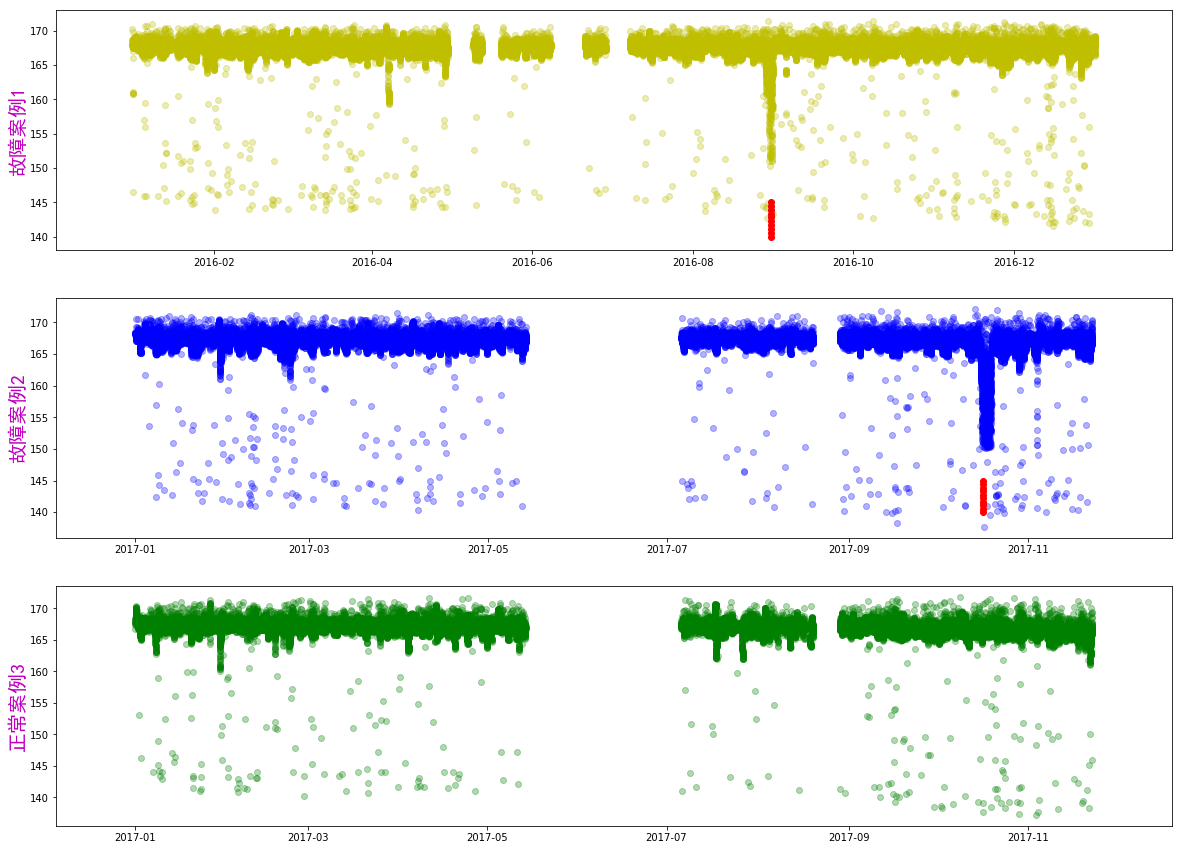

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.scatter(df1['r55'].index, df1['r55'].values, alpha=0.3, color='y')
plt.scatter(['2016-08-30 16:42:00']*10, np.linspace(140, 145, 10), color='r') # 报故障时间
plt.ylabel('故障案例1',fontproperties='SimHei', fontsize=20, color='m')

plt.subplot(3,1,2)
plt.scatter(df2['r55'].index, df2['r55'].values, alpha=0.3, color='b')
plt.scatter(['2017-10-16 17:11:00']*10, np.linspace(140, 145, 10), color='r') # 报故障时间
plt.ylabel('故障案例2',fontproperties='SimHei', fontsize=20, color='m')

plt.subplot(3,1,3)
plt.scatter(df3['r55'].index, df3['r55'].values, alpha=0.3, color='g')
plt.ylabel('正常案例3',fontproperties='SimHei', fontsize=20, color='m')

plt.show()

###  4.2 故障附近时序图

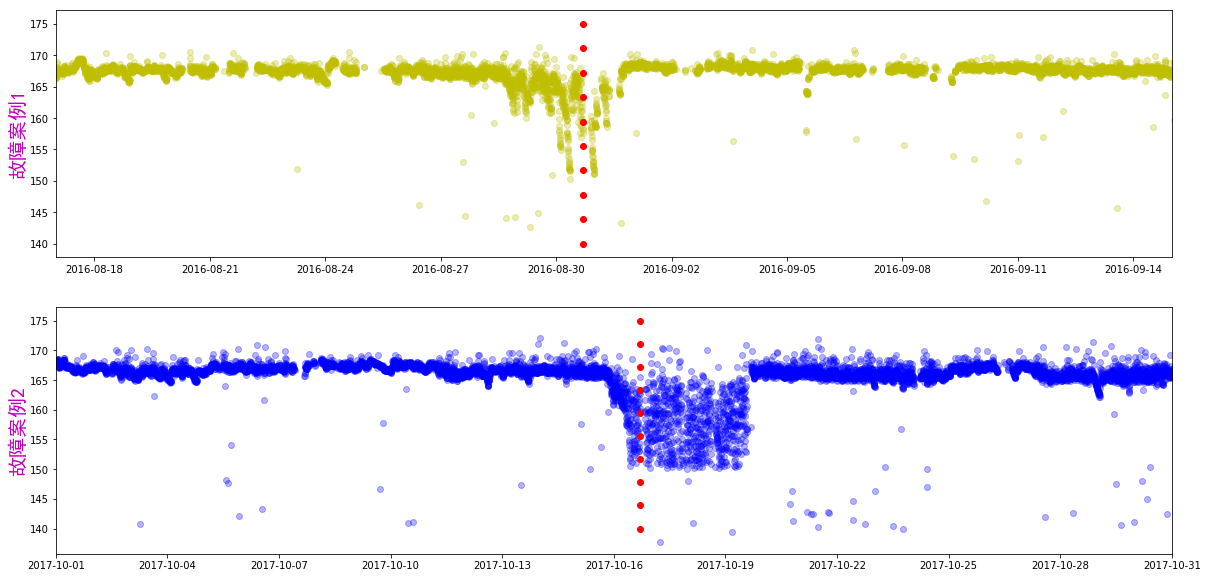

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
df1_near = df1.loc['2016-08-17':'2016-09-17',:]
plt.scatter(df1_near['r55'].index, df1_near['r55'].values, alpha=0.3, color='y')
plt.scatter(['2016-08-30 16:42:00']*10, np.linspace(140, 175, 10), color='r') # 报故障时间
plt.xlim(['2016-08-17', '2016-09-15'])
plt.ylabel('故障案例1',fontproperties='SimHei', fontsize=20, color='m')

plt.subplot(2,1,2)
df2_near = df2.loc['2017-10-01':'2017-10-31',:]
plt.scatter(df2_near['r55'].index, df2_near['r55'].values, alpha=0.3, color='b')
plt.scatter(['2017-10-16 17:11:00']*10, np.linspace(140, 175, 10), color='r') # 报故障时间
plt.xlim(['2017-10-01', '2017-10-31'])
plt.ylabel('故障案例2',fontproperties='SimHei', fontsize=20, color='m')

plt.show()

## 5  报警阈值选择
* 前x小时超过阈值y的次数超过z时，报警
* x ： 4个小时
* y ： 下限为163Bar，上限为175Bar
* z ： 10次

In [34]:
df1_c = df1.copy()
df2_c = df2.copy()
df3_c = df3.copy()

# 阈值设置
thres_min = 163
thres_max = 175

#
df1_c['r55'] = df1_c['r55'].apply(lambda x: 1 if (x <= thres_min) or (x >= thres_max) else 0)
df2_c['r55'] = df2_c['r55'].apply(lambda x: 1 if (x <= thres_min) or (x >= thres_max) else 0)
df3_c['r55'] = df3_c['r55'].apply(lambda x: 1 if (x <= thres_min) or (x >= thres_max) else 0)

# 5min抽样，缺失值填0
df1_c = df1_c.resample('5min',label='left').first()
df2_c = df2_c.resample('5min',label='left').first()
df3_c = df3_c.resample('5min',label='left').first()

df1_c = df1_c.fillna(0)
df2_c = df2_c.fillna(0)
df3_c = df3_c.fillna(0)

window = 24 # 相当于4H
df1_c = df1_c.rolling(window=window,center=False).sum()
df2_c = df2_c.rolling(window=window,center=False).sum()
df3_c = df3_c.rolling(window=window,center=False).sum()


### 5.1 全年超出阈值次数显示

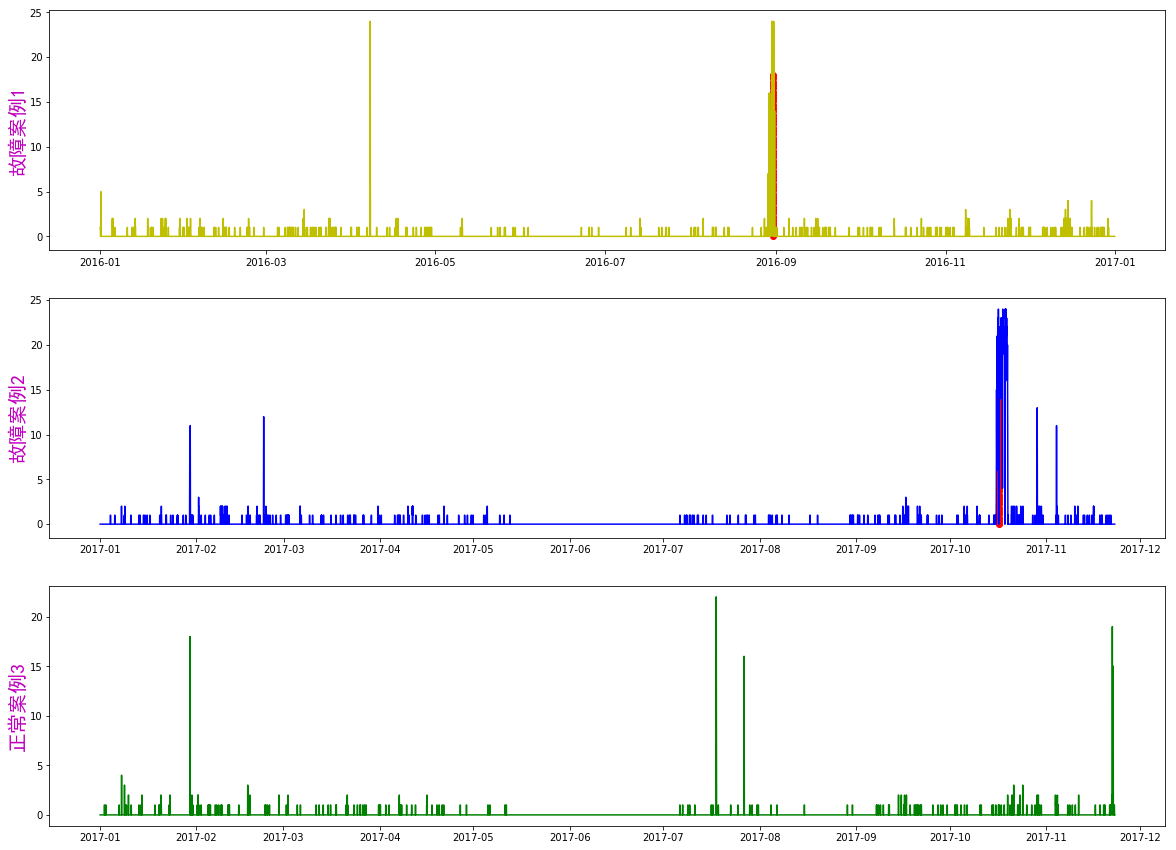

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))

plt.subplot(3,1,1)
plt.plot(df1_c['r55'], color='y')
plt.scatter(['2016-08-30 16:42:00']*50, np.linspace(0, 18, 50), color='r') # 报故障时间
plt.ylabel('故障案例1',fontproperties='SimHei', fontsize=20, color='m')

plt.subplot(3,1,2)
plt.plot(df2_c['r55'], color='b')
plt.scatter(['2017-10-16 17:11:00']*50, np.linspace(0, 18, 50), color='r') # 报故障时间
plt.ylabel('故障案例2',fontproperties='SimHei', fontsize=20, color='m')

plt.subplot(3,1,3)
plt.plot(df3_c['r55'], color='g')
plt.ylabel('正常案例3',fontproperties='SimHei', fontsize=20, color='m')

plt.show()

### 5.2 故障附近超出阈值次数显示

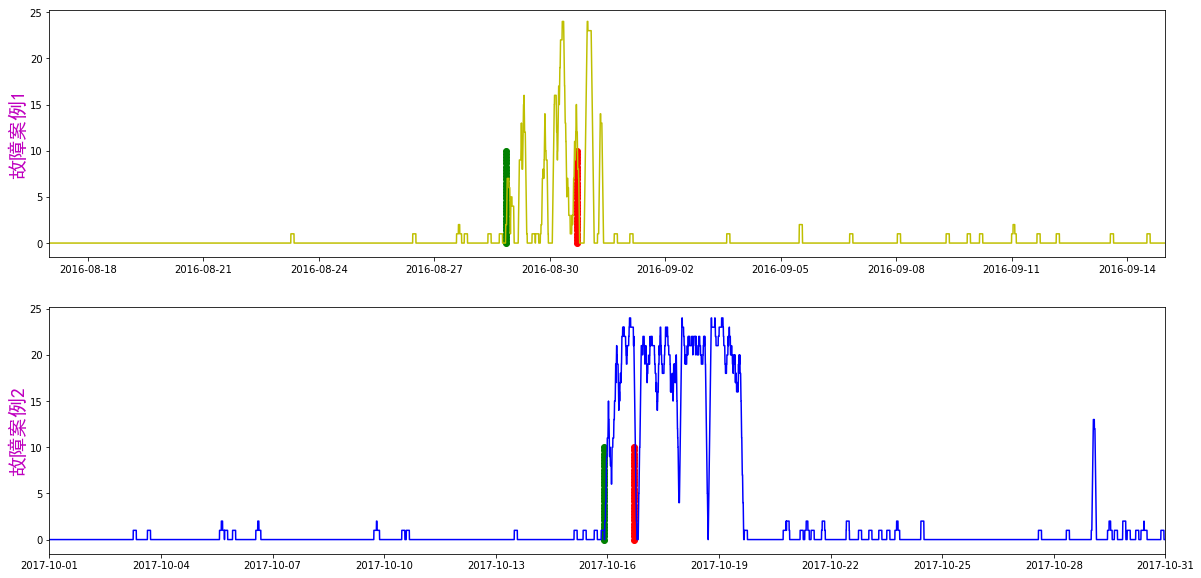

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)
# plt.plot(pf.index,len(pf.index)*[thres_time[0]],'g--',alpha=0.5)
plt.plot(df1_c['r55'], color='y')
plt.scatter(['2016-08-28 21:00:00']*30, np.linspace(0, 10, 30), color='g') # 报故障时间
plt.scatter(['2016-08-30 16:42:00']*30, np.linspace(0, 10, 30), color='r') # 报故障时间
plt.xlim(['2016-08-17', '2016-09-15'])
plt.ylabel('故障案例1',fontproperties='SimHei', fontsize=20, color='m')

plt.subplot(2,1,2)
# plt.plot(pf.index,len(pf.index)*[thres_time[0]],'g--',alpha=0.5)
plt.plot(df2_c['r55'], color='b')
plt.scatter(['2017-10-15 22:00:00']*30, np.linspace(0, 10, 30), color='g') # 报故障时间
plt.scatter(['2017-10-16 17:11:00']*30, np.linspace(0, 10, 30), color='r') # 报故障时间
plt.xlim(['2017-10-01', '2017-10-31'])
plt.ylabel('故障案例2',fontproperties='SimHei', fontsize=20, color='m')

plt.show()

## 6 结论
* 偏航夹钳断裂故障，可以使用液压系统压力数据进行预警
* 当前x小时超出压力阈值y的次数到达z时，进行报警
* 可以看出，实际故障预警可以提前约1~2天左右
* 本模型存在一定的误报，实际应用可以灵活的调节阈值x,y,z